In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import pipeline
import plutil

from smart_open import s3
from tqdm import tqdm

from plutil import DocMeta, ArtMeta

## Step 0: Set up pipeline

In [ ]:
bucket_name = 'cuecon-textlab'
bucket_prefix = 'home/research/corpora/contracts/canadian/txt/'

In [ ]:
#pl = pipeline.Pipeline("canadian", canadian_pt_path, lang_list=["eng"],
#                       sample_N=100, splitter="elliott")
s3_options = {
    'bucket_name': 'cuecon-textlab',
    'bucket_prefix': 'home/research/corpora/contracts/canadian/txt/'
}
pl = pipeline.Pipeline("canadian", mode="s3", mode_options=s3_options,
                       output_dirname="2022-08-jeff-python", lang_list=["eng"],
                       splitter="elliott", verbose=True)

In [ ]:
len(pl.excluded_fnames)

In [ ]:
pl.excluded_fnames[0], pl.excluded_fnames[-1]

## Step 1: Split contract text into individual articles

Using the regex method or elliott's method

In [ ]:
# Get the paths to the folders where the pkl and json files should be saved
artsplit_pkl_path = pl.get_artsplit_output_path("pkl")
print(artsplit_pkl_path)

In [ ]:
import detect_sections_elliott as dse

In [ ]:
def split_contract(contract_text, contract_meta):
    arts, headers = dse.detect_sections(contract_text)
    # Convert to the dict format for compatibility with regex splitter
    # It looks like len(headers) is almost always greater than (often
    # like double or triple) len(arts). So for now I'm ignoring headers
    art_list = []
    for i in range(len(arts)):
        cur_art_text = arts[i]
        cur_art_meta = ArtMeta(contract_meta.contract_id, contract_meta.lang, i)
        art_list.append((cur_art_text, cur_art_meta))
    return art_list

In [ ]:
save_json = False

In [ ]:
accept_rule = lambda fname: fname.endswith('_eng.txt')
# Include key_limit=16 for debugging
bucket_iter = s3.iter_bucket(bucket_name, prefix=bucket_prefix,
                             accept_key=accept_rule, workers=16, key_limit=100)
for fpath, content in tqdm(bucket_iter, total=pl.get_num_docs()):
    fname = os.path.basename(fpath)
    # First we get the info from the filename
    fname_data = plutil.parse_fname(fname)
    contract_prefix = fname_data['prefix']
    contract_meta = DocMeta(fname_data['id'], fname_data['lang'])
    # Now we process the content
    #print(fname, len(content))
    contract_text = content.decode('utf-8')
    art_list = split_contract(contract_text, contract_meta)
    # And save the article list as .pkl (for internal use) and .json
    # (for human reading)
    pkl_fpath = os.path.join(pl.get_artsplit_output_path("pkl"), f"{contract_prefix}.pkl")
    plutil.safe_to_pickle(art_list, pkl_fpath)
    #print(f"Saved to {pkl_fpath}")
    if save_json:
        json_fpath = os.path.join(pl.get_artsplit_output_path("json"), f"{contract_prefix}.json")
        plutil.safe_to_json(art_list, json_fpath)

## Step 2: Parse the articles using spaCy, resolve coreference

In [ ]:
#!pip install multiprocessing_logging

In [ ]:
# Python imports
import functools
import glob
import json
import logging
import os

# 3rd party imports
import joblib

# Local imports
import pipeline
from plutil import DocMeta, ArtMeta

In [ ]:
# Set up logging
logger = logging.getLogger()
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

In [ ]:
# And set it to work with spacy's use of multiprocessing
import multiprocessing_logging
multiprocessing_logging.install_mp_handler()

In [ ]:
nlp_eng = pl.get_spacy_model()

In [ ]:
def stream_art_lists(test_N=None):
    """

    :param test_N:
    :return:
    """
    art_data_fpaths = glob.glob(os.path.join(artsplit_pkl_path, "*.pkl"))
    for fnum, fpath in enumerate(art_data_fpaths):
        if test_N is not None and fnum >= test_N:
            # We've already yielded the first `test_N` contracts, so terminate
            break
        # Get the contract info from the fpath
        fname = os.path.basename(fpath)
        fname_data = plutil.parse_fname(fname)
        contract_meta = DocMeta(fname_data['id'], fname_data['lang'])
        contract_articles = joblib.load(fpath)
        yield contract_articles, contract_meta


In [ ]:
#art_data_fpaths = glob.glob("../canadian_output/01_artsplit_elliott_json/*.json")
#first_fpath = art_data_fpaths[0]
#with open(first_fpath, 'r') as f:
#    data = json.load(f)

In [ ]:
def remove_unserializable_results(doc):
    doc.user_data = {}
    for x in dir(doc._):
        if x in ['get', 'set', 'has']: continue
        setattr(doc._, x, None)
    for token in doc:
        for x in dir(token._):
            if x in ['get', 'set', 'has']: continue
            setattr(token._, x, None)
    return doc

In [ ]:
def get_coref_data(doc_obj):
    mentions = [
        {
            "start": mention.start_char,
            "end": mention.end_char,
            "text": mention.text,
            "resolved": cluster.main.text,
        }
        for cluster in doc_obj._.coref_clusters
        for mention in cluster.mentions
    ]
    return mentions

In [ ]:
def transform_texts(nlp, batch_id, batch_tuples, output_dir):
    batch_results = []
    #print(nlp.pipe_names)
    output_fpath = os.path.join(output_dir, f"{batch_id}.pkl")
    if os.path.isfile(output_fpath):  # return None in case same batch is called again
        return None
    print("Processing batch", batch_id)
    for art_doc, art_meta in nlp.pipe(batch_tuples, as_tuples=True):
        # This is the weird part where we now have to change contract_id and art_num
        # from being metadata to being attributes of the spacy Doc objects themselves
        contract_id = art_meta["contract_id"]
        article_num = art_meta["article_num"]
        art_doc._.contract_id = contract_id
        art_doc._.article_num = article_num
        # And now we don't need the meta object anymore, since it's encoded in the Doc itself
        # But next we need to get a serializable representation of the detected corefs
        art_doc._.coref_list = get_coref_data(art_doc)
        # Ok now we can get rid of the original coref attributes that break the data
        art_doc = remove_unserializable_results(art_doc)
        batch_results.append(art_doc)
    # And save the bytes object to file
    joblib.dump(batch_results, output_fpath)
    print(f"Saved {len(batch_tuples)} texts to {output_fpath}")

In [ ]:
def spacy_parse_article(nlp, art_str):
    art_doc = nlp(art_str)
    ## But next we need to get a serializable representation of the detected corefs
    #art_doc._.coref_list = get_coref_data(art_doc)
    ## Ok now we can get rid of the original coref attributes that break the data
    #art_doc = remove_unserializable_results(art_doc)
    return art_doc

In [ ]:
spacy_output_path = pl.get_spacy_output_path()
contract_iter = tqdm(stream_art_lists())
for art_list, contract_meta in contract_iter:
    contract_id = contract_meta.get_contract_id()
    contract_fname = contract_meta.gen_fname("pkl")
    output_fpath = os.path.join(spacy_output_path, contract_fname)
    # Check if it's already been processed
    if os.path.isfile(output_fpath):
        continue
    contract_art_list = []
    #print(contract_data)
    #print(f"Processing contract {contract_id}")
    contract_iter.set_description(contract_id)
    pl.vprint(f"Parsing {len(art_list)} articles")
    for cur_art_text, cur_art_meta in art_list:
        cur_art_doc = spacy_parse_article(nlp_eng, cur_art_text)
        contract_art_list.append((cur_art_doc, cur_art_meta))
    #print(cur_art_doc)
    # Save the contract docs
    plutil.safe_to_pickle(contract_art_list, output_fpath)

## Step 3: Extract the spaCy dependency parse data (to csv format)

In [ ]:
from collections import Counter

import process_spacy as pspacy
from plutil import DocMeta, ArtMeta

import pandas as pd

In [ ]:
nlp_eng = pl.get_spacy_model()

### First extract the statement data (sdata)

In [ ]:
def get_num_contract_parses():
    spacy_fpaths = glob.glob(os.path.join(spacy_output_path, "*.pkl"))
    return len(spacy_fpaths)

def stream_contract_parses():
    spacy_fpaths = glob.glob(os.path.join(spacy_output_path, "*.pkl"))
    for cur_fpath in spacy_fpaths:
        fname = os.path.basename(cur_fpath)
        fname_data = plutil.parse_fname(fname)
        contract_id = fname_data['id']
        contract_lang = fname_data['lang']
        contract_meta = DocMeta(contract_id, contract_lang)
        # A list where each element is the spaCy parse of one article within the contract
        cur_art_parse_list = joblib.load(cur_fpath)
        yield cur_art_parse_list, contract_meta

def save_pdata_df(pdata_df, chunk_num=None):
    suffix = ""
    if chunk_num:
        suffix = f"_{str(chunk_num)}"
    pdata_fpath = os.path.join(pl.get_pdata_path(), f"{pl.get_corpus_name()}_pdata{suffix}.pkl")
    plutil.safe_to_pickle(pdata_df, pdata_fpath)

In [151]:
num_parses = get_num_contract_parses()
for cur_contract_data in tqdm(stream_contract_parses(), total=num_parses):
    cur_contract_parses = cur_contract_data[0]
    cur_contract_meta = cur_contract_data[1]
    cur_contract_id = cur_contract_meta.contract_id
    # A list of lists, where each element is the list of statements within an article
    contract_statement_lists = []
    # The generator gives a list of parses, so run get_statements() on each item
    for cur_art_data in cur_contract_parses:
        #print(cur_art_data)
        cur_art_parse = cur_art_data[0]
        cur_art_meta = cur_art_data[1]
        cur_art_statements = pspacy.get_statements(cur_art_parse, cur_contract_id, cur_art_meta.art_num)
        contract_statement_lists.append(cur_art_statements)
    # Now serialize
    output_fname = cur_contract_meta.gen_fname("pkl")
    output_fpath = os.path.join(pl.get_sdata_output_path(), output_fname)
    plutil.safe_to_pickle(contract_statement_lists, output_fpath)

100%|██████████| 100/100 [05:32<00:00,  3.33s/it]


In [ ]:
pl.vprint("Starting extract_pdata()")
pdata_path = pl.get_pdata_path()
subject_counts = Counter()
subnoun_counts = Counter()
modal_counts = Counter()

### Now we extract the parse data (pdata) for each statement

In [ ]:
# Loop over the items, getting counts but also producing a .csv where each
# row is a statement
# Num to process is just num_contracts
num_to_process = pl.get_num_docs()
# Counting individual loop iterations
iteration_num = 0
# Counting the number of times we save and clear the accumulated data
chunk_num = 0
pdata_rows = []
for statement_data in tqdm(stream_contract_parses(), total=num_to_process):
    contract_id = statement_data["contract_id"]
    # Loop over each statement, getting the subject/subject_branch/subject_tag
    subject = statement_data['subject']
    statement_dict = {
        'contract_id':contract_id,
        'article_num':statement_data['article_num'],
        'sentence_num':statement_data['sentence_num'],
        'statement_num':statement_data['statement_num'],
        'full_sentence':statement_data['full_sentence'],
        'full_statement':statement_data['full_statement'],
        'subject':statement_data['subject'],
        'passive':statement_data['passive'],
        'subject_tags':statement_data['subject_tags'],
        'subject_branch':statement_data['subject_branch'],
        'object_tags':statement_data['object_tags'],
        'verb':statement_data['verb'],
        'modal':statement_data['modal'],
        'md':statement_data['md'],
        'neg':statement_data['neg'],
        'object_branches':statement_data['object_branches']
    }
    pdata_rows.append(statement_dict)
    subnouns = sorted([subject_branch
                       for subject_branch, subject_tag
                       in zip(statement_data['subject_branch'], statement_data['subject_tags'])
                       if subject_tag.startswith('N')])
    subject_counts[subject] += 1
    if statement_data['md'] == 1:
        modal_counts[subject] += 1
    for x in subnouns:
        if x != subject:
            subnoun_counts[x] += 1
    iteration_num = iteration_num + 1
    # Print a message and save the statements every 100k
    if iteration_num % 100000 == 0:
        pl.vprint(f"Iteration {iteration_num}: Saving [Processing contract {contract_id}]")
        cur_df = pd.DataFrame(pdata_rows)
        pl.save_pdata_df(cur_df, chunk_num)
        chunk_num = chunk_num + 1
        pdata_rows.clear()
# Make a Pandas df out of whatever's left in pdata_rows and save it
cur_df = pd.DataFrame(pdata_rows)
pl.save_pdata_df(cur_df, chunk_num)
sub_counts_fpath = os.path.join(pl.get_output_path(), f"{pl.get_corpus_name()}_subject_counts.pkl")
pd.to_pickle(subject_counts, sub_counts_fpath)
modal_counts_fpath = os.path.join(pl.get_output_path(), f"{pl.get_corpus_name()}_modal_counts.pkl")
pd.to_pickle(modal_counts, modal_counts_fpath)

print("Most common subjects:")
print(subject_counts.most_common()[:50])

## Step 4: Compute authority measures

In [ ]:
subject_dict = {
    'other':0,'worker':1,'union':2,'firm':3,'manager':4
}
# And make it reversible
for k, v in subject_dict.items():
    subject_dict[v] = k

snpdata_header = [
    "contract_id","section_num","sentence_num","statement_num","md",
    "strict_modal","neg","passive","verb","object_branches","full_sentence"]

In [152]:
def check_neg(statement_row):
    return statement_row['neg'] == 'not'

def check_strict_modal(statement_row):
    strict_modal = False
    if statement_row['md']:
        strict_modal = statement_row['modal'] in ['shall','must','will']
    return strict_modal

In [ ]:
def compute_statement_auth(pl, chunk_num, pdata_chunk_df):
    pl.iprint(f"starting compute_statement_auth()")
    # Uncomment below if the corpus is small enough to be processed all at once
    #pdata_df = pl.load_pdata_df()
    ### Add some initial columns to the df that will help us when we compute
    ### auth measures below
    vars_to_keep = ["contract_id","article_num","sentence_num","statement_num",
                    "subject","md","verb","passive","full_sentence"]
    ### Soo after this we're grabbing stuff out of auth_df A LOT.
    ### so I'm renaming it to just df
    df = pdata_chunk_df[vars_to_keep].copy()
    # We can save memory by converting some of the ints to bools
    df["md"] = df["md"].astype('bool')
    df["passive"] = df["passive"].astype('bool')
    df["subject"] = df["subject"].str.lower()
    df["subnorm"] = df["subject"].apply(pl.normalize_subject)
    # Strict modal check. axis=1 means apply row-by-row
    df["strict_modal"] = pdata_chunk_df.apply(check_strict_modal,axis=1).astype('bool')
    df["neg"] = pdata_chunk_df['neg'].apply(lambda x: x == 'not').astype('bool')

    with tqdm(total=13) as pbar:
        df['count'] = 1
        # permissive modals are may and can
        df['permissive_modal'] = (df['md'] & ~df['strict_modal']).astype('bool')
        pbar.update(1)

        # obligation verbs
        df_passive = df['passive']
        df['obligation_verb'] = (df_passive &
                                 df['verb'].isin(['require', 'expect', 'compel', 'oblige', 'obligate'])).astype('bool')
        pbar.update(1)

        # constraint verbs
        df['constraint_verb'] = (df_passive &
                                 df['verb'].isin(['prohibit', 'forbid', 'ban', 'bar', 'restrict', 'proscribe'])).astype('bool')
        pbar.update(1)

        # permissiion verbs are be allowed, be permitted, and be authorized
        df['permission_verb'] =  (df_passive &
                                  df['verb'].isin(['allow', 'permit', 'authorize'])).astype('bool')
        pbar.update(1)

        df_notpassive = ~df_passive
        df['entitlement_verb'] =  (df_notpassive &
                                   df['verb'].isin(['have', 'receive','retain'])).astype('bool')
        pbar.update(1)

        df['promise_verb'] = (df_notpassive &
                              df['verb'].isin(['agree','promise','commit','recognize',
                                               'consent','assent','affirm','assure',
                                               'guarantee','insure','ensure','stipulate',
                                               'undertake','pledge'])).astype('bool')
        pbar.update(1)

        pl.dprint("Computed up to promise_verb")

        df['special_verb'] = (df['obligation_verb'] | df['constraint_verb'] | df['permission_verb'] | df['entitlement_verb'] | df['promise_verb']).astype('bool')
        pbar.update(1)


        df['active_verb'] = (df_notpassive & ~df['special_verb']).astype('bool')
        pbar.update(1)

        #df['verb_type'] = 0 + 1 *df['passive'] + 2*df['obligation_verb'] + 3*df['constraint_verb'] + 4*df['permission_verb'] + 5*df['entitlement_verb']

        df_neg = df['neg']
        df_notneg = ~df_neg
        df['obligation'] = ((df_notneg & df['strict_modal'] & df['active_verb']) |     #positive, strict modal, action verb
                            (df_notneg & df['strict_modal'] & df['obligation_verb']) | #positive, strict modal, obligation verb
                            (df_notneg & ~df['md'] & df['obligation_verb'])).astype('bool') #positive, non-modal, obligation verb
        pbar.update(1)

        df['constraint'] = ((df_neg & df['md'] & ~df['obligation_verb']) | # negative, any modal, any verb except obligation verb
                            (df_notneg & df['strict_modal'] & df['constraint_verb'])).astype('bool') # positive, strict modal, constraint verb
        pbar.update(1)

        df['permission'] = ((df_notneg & ( (df['permissive_modal'] & df['active_verb']) |
                                           df['permission_verb'])) |
                            (df['neg'] & df['constraint_verb'])).astype('bool')
        pbar.update(1)


        df['entitlement'] = ((df_notneg & df['entitlement_verb']) |
                             (df_notneg & df['strict_modal'] & df['passive']) |
                             (df_neg & df['obligation_verb'])).astype('bool')
        pbar.update(1)
    pl.iprint("Authority measures computed.")
    pl.save_statement_auth(df, chunk_num)

    #grp.replace(np.nan,0,inplace=True)
    #pickle_filename = output_prefix + "-excerpt.pkl"
    #grp.to_pickle(pickle_filename)

    #df.to_pickle('df-contract-1.pkl')

### And combine the individual batches to get one file per contract

In [ ]:
auth_path = pl.get_statement_auth_path()
fpath_data = plu.sort_by_suffix(auth_path)
new_fname = plu.remove_suffix(auth_path)
auth_df = pd.DataFrame()
for fnum, fpath in fpath_data:
    cur_df = pd.read_pickle(fpath)
    auth_df = pd.concat([auth_df,cur_df])
# Once combined, save a version without a numeric suffix
plutil.safe_to_pickle(auth_df, os.path.join(pl.get_output_path(), new_fname))

### Step 6: Sum authority measures to contract level

In [ ]:
def sum_auth(pl):
    """ Takes the authority measures computed by compute_auth.py and sums them
    to the contract level

    Requires:
    """
    #breakpoint()
    pl.iprint("sum_auth()")
    # Loads the df chunks in 04_<corpus>_auth folder produced by compute_auth and sums
    # them together to the contract level
    summed_df = None
    for chunk_num, cur_chunk_df in pl.stream_statement_auth():
        # Sum the current chunk
        summed_chunk_df = sum_auth_df(pl, cur_chunk_df)
        # And concatenate it to the full-data df
        if summed_df is None:
            summed_df = summed_chunk_df
        else:
            summed_df = pd.concat([summed_df, summed_chunk_df])
    # Now we do a final sum to obtain the (non-chunked) contract-level dataset
    final_summed_df = summed_df.groupby(["contract_id"]).sum()
    final_summed_df.reset_index(inplace=True)
    pl.save_authsums_df(summed_df)

    sum_csv_fpath = pl.get_authsums_fpath(extension="csv")
    sum_df.to_csv(sum_csv_fpath, index=False)
    sum_pkl_fpath = pl.get_authsums_fpath(extension="pkl")
    sum_df.to_pickle(sum_pkl_fpath)
    pl.iprint("Saved " + str(sum_csv_fpath))

def sum_auth_df(auth_df):
    """
    Helper function for sum_auth(), which sums up a *single* (chunk) dataframe containing
    auth measures, so that they can be combined into one final summed df by sum_auth()
    """
    unique_ids = ["contract_id","subnorm"]
    grp_df = auth_df.groupby(unique_ids).sum()
    grp_df.reset_index(inplace=True)
    def conditional_measure(x,subnorm,measure):
        # This function returns the actual measure if the subnorm of the row
        # is equal to the subnorm argument, and 0.0 otherwise. This makes it
        # so that when we "sum" up to just contract_id we get just the measure
        # for the subnorm of interest
        return x[measure] if x["subnorm"]==subnorm else 0.0
    subnorms_to_process = pl.subnorm_list
    if "other" in subnorms_to_process:
        subnorms_to_process.remove("other")
    for cur_measure in pl.AUTH_MEASURES:
        pl.iprint("Making cols for " + cur_measure)
        for cur_subnorm in subnorms_to_process:
            print("Making cols for " + cur_measure + " x " + cur_subnorm)
            new_col_name = cur_measure + "_" + cur_subnorm
            grp_df[new_col_name] = grp_df.apply(conditional_measure,
                                                axis="columns",args=(cur_subnorm,cur_measure))
    # And now just sum! It's not actually summing anything, just getting rid
    # of all the 0.0 cells, for example permission_worker in a row with subnorm firm
    sum_df = grp_df.groupby(["contract_id"]).sum()
    sum_df.reset_index(inplace=True)

    # Return it so these summed chunk dfs can be combined into a final summed df
    # by sum_auth()
    return sum_df

## Step 6: Compute corpus-wide summary stats

In [153]:
import plutil

In [ ]:
# Change this list to change which conditionals get counted
cond_list = ["if","in_case","where","were","had","could","unless","should",
             "as_long_as","so_long_as","provided_that","otherwise","supposing"]

def compute_word_counts(pl):
    # There are actually two different possible word counts: the first is just
    # the number of tokens in the word-tokenized plaintext. This, to me, is not
    # what we want, since (for example) if there are a bunch of spaces between
    # each letter this method will produce some huge number of tokens, even
    # though each token is actually just one letter. So I think what we want to
    # do instead is count the number of words in the full_sentence values for
    # each contract.
    pl.iprint("compute_word_counts()")
    auth_df = pl.get_latest_auth_df()
    # First, while it's at the statement level, compute counts
    vars_to_keep = ["contract_id","article_num","sentence_num","statement_num",
                    "full_sentence","subnorm"]
    wc_df = auth_df[vars_to_keep].copy()
    wc_df["statement_count"] = 1
    # Subnorm-specific counts
    main_subnorms = pl.subnorm_list
    main_subnorms.remove("other")
    for cur_subnorm in main_subnorms:
        count_var = cur_subnorm + "_count"
        wc_df[count_var] = wc_df["subnorm"] == cur_subnorm
        wc_df[count_var] = wc_df[count_var].astype(int)
    # Aggregate to sentence level (full_sentence is redundant for different
    # statements within the same sentence)
    wc_groups = wc_df.groupby(['contract_id','article_num','sentence_num'])
    pl.iprint("Summing to sentence level")
    agg_dict = {'full_sentence':'first','statement_count':'sum','firm_count':'sum',
                'manager_count':'sum','union_count':'sum','worker_count':'sum'}
    sent_df = wc_groups.agg(agg_dict)
    # slow :(
    #main_subnorms = pl.subnorm_list
    #main_subnorms.remove("other")
    #main_subnorms = ["firm"]
    #for cur_subnorm in main_subnorms:
    #    cur_count_var = cur_subnorm + "_count"
    #    pl.iprint("Computing " + str(cur_count_var))
    #    sent_df[cur_count_var] = auth_groups["subnorm"].agg(lambda x:(x==cur_subnorm).sum())

    # Count the words. This regex method is faster than any other, according to
    # some stackoverflow post I'm too lazy to find again
    wordcount = re.compile(r'\w+')
    def num_tokens(sent_str):
        return len(wordcount.findall(sent_str))
    pl.iprint("Computing num_words")
    sent_df["num_words"] = sent_df["full_sentence"].apply(num_tokens)
    pl.iprint("Finished computing num_words")

    def count_conditionals(sent_str):
        # Uncomment this line if you want to produce a *vector* of counts, i.e.,
        # how many times each separate conditional appears in the string
        #count_vec = cur_text.count(cur_cond.replace("_"," ")) for cur_cond in cond_list]
        # Otherwise, we just sum all these individual counts up to get one final
        # conditional count
        return sum([sent_str.count(cur_cond.replace("_"," ")) for cur_cond in cond_list])
    sent_df["conditional_count"] = sent_df["full_sentence"].apply(count_conditionals)
    pl.iprint("Finished counting conditionals")

    # LIWC counts
    def num_matches(reg_str, test_str):
        # NaNs, by definition, have zero matches, but Python blows up if we don't
        # manually specify...
        if str(test_str) == "nan":
            return 0
        num_matches = len(re.findall(reg_str,test_str))
        return num_matches
    # Loop over each category specified by LIWC_DICT in pipeline.py
    for cur_liwc_cat in pl.LIWC_FPATHS:
        pl.iprint("Counting LIWC category: " + str(cur_liwc_cat))
        # Get the filename of the current LIWC file
        cur_liwc_fpath = pl.LIWC_FPATHS[cur_liwc_cat]
        cur_liwc_list = plu.stopwords_from_file(cur_liwc_fpath)
        cur_regex = plu.list_to_regex(cur_liwc_list)
        col_name = "liwc_" + str(cur_liwc_cat) + "_count"
        sent_df[col_name] = sent_df.apply(lambda row: num_matches(cur_regex, row["full_sentence"]), axis=1)

    #print(sent_df.head())
    #print(sent_df.columns)
    pl.iprint("Finished LIWC counts")

    # And aggregate to contract level
    article_df = sent_df.groupby(["contract_id","article_num"]).sum()
    contract_df = article_df.groupby(["contract_id"]).sum()
    contract_df.reset_index(inplace=True)

    output_csv_fpath = pl.get_sumstats_fpath(extension="csv")
    pl.iprint("Saving sumstats to " + output_csv_fpath)
    output_pkl_fpath = pl.get_sumstats_fpath(extension="pkl")
    plu.safe_to_csv(contract_df, output_csv_fpath, index=False)
    plu.safe_to_pickle(contract_df, output_pkl_fpath)
    output_dta_fpath = pl.get_sumstats_fpath(extension="dta")
    plu.safe_to_stata(contract_df, output_dta_fpath)

## Step 7: Merge the auth data with all other contract metadata

In [ ]:

def merge_text_meta(pl):
    pl.dprint("merge_text_meta()")
    # Merges the full contract-level dataset created by generateContractAuth()
    # with the metadata in <corpus_name>_meta.csv
    authsums_pkl_fpath = pl.get_authsums_fpath(extension="pkl")
    pl.iprint("Loading authsums file " + authsums_pkl_fpath)
    authsums_df = pd.read_pickle(authsums_pkl_fpath)
    # And make sure the contract_id is the index (unique key)
    # Fuck it. Pandas is so finicky I'm just gonna ALWAYS ignore the index. So
    # all columns will just be regular columns, and we'll never look at or care
    # about the index column. Rrrrrgh.
    #contract_df.set_index(plu.UID_CONTRACT,inplace=True)
    # Also the contract_id column here sometimes gets loaded as float64, whereas
    # in the other file it gets loaded as int64. Again, rrrrrgh.
    # TODO: figure out why the hell this happens. 264 contracts have some
    # weird hex string as its contract_id
    #authsum_df = authsum_df[~authsum_df.contract_id.str.contains('\xa0')]
    authsums_df["contract_id"] = pd.to_numeric(authsums_df["contract_id"],errors='coerce')

    meta_fpath = pl.get_meta_fpath()
    pl.iprint("Loading meta file " + str(meta_fpath))
    meta_df = plu.safe_read_data(meta_fpath)
    # contract_id unique key
    #meta_df.set_index(plu.UID_CONTRACT,inplace=True)

    # Merge on contract_id
    merged_df = authsums_df.merge(meta_df, how='inner', on=['contract_id'])
    output_csv_fpath = pl.get_merged_meta_fpath(extension="csv")
    output_pkl_fpath = pl.get_merged_meta_fpath(extension="pkl")
    pl.iprint("Saving " + output_pkl_fpath)
    # Make sure contract is unique id
    #merged_df.set_index(plu.UID_CONTRACT,inplace=True)
    plu.safe_to_csv(merged_df, output_csv_fpath)
    plu.safe_to_pickle(merged_df, output_pkl_fpath)
    # And update the pipeline to reflect that the basic metadata has been
    # successfully merged
    pl.last_merge_csv_fpath = output_csv_fpath
    pl.last_merge_pkl_fpath = output_pkl_fpath

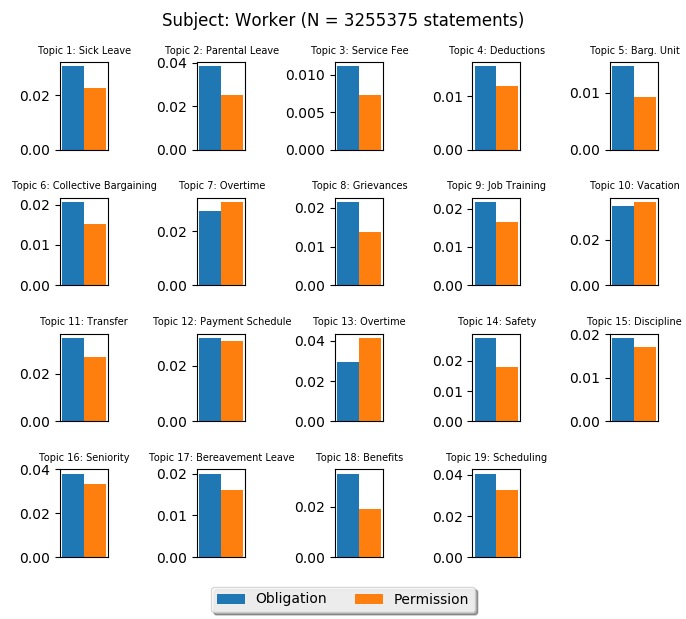